In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb

In [2]:
features_num = [
    'Total_flux', 'Peak_flux', 
       'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 'R_flux_corr',
       'I_flux_corr', 'z_flux_corr', 'y_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 'Ks_flux_corr',
       'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'Z_BEST', 'r_rcs_flux_corr',
       'g_flux_corr', 'nb921_hsc_flux_corr'
    ]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

In [4]:
data = pd.read_csv("../../Data/Fangyou_data/Cleaned/combined_using_similar_columns.csv")

In [5]:
X = data[features_num]
y = data[np.append(y_column, ['Xray', 'Opt_spec', 'Extended_radio', 'IRAGN'])]

In [6]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
X.describe()

,Total_flux,Peak_flux,NUV_flux_corr,u_flux_corr,Bw_flux_corr,R_flux_corr,I_flux_corr,z_flux_corr,y_flux_corr,J_flux_corr,H_flux_corr,K_flux_corr,Ks_flux_corr,ch1_flux_corr,ch2_flux_corr,ch3_flux_corr,ch4_flux_corr,F_MIPS_24,F_PACS_100,F_PACS_160,F_SPIRE_250,F_SPIRE_350,F_SPIRE_500,Z_BEST,r_rcs_flux_corr,g_flux_corr,nb921_hsc_flux_corr
count,7.760900e+04,7.760900e+04,58159.000000,69885.000000,17144.000000,75506.000000,73130.000000,7.460100e+04,44999.000000,67393.000000,17297.000000,63114.000000,17244.000000,76934.000000,77573.000000,75854.000000,76250.000000,73853.000000,76713.000000,76713.000000,73638.000000,73638.000000,73638.000000,77609.000000,72688.000000,5.734600e+04,2.809500e+04
mean,2.291950e+03,1.146907e+03,0.829133,3.101983,4.839450,15.618864,24.087127,3.132064e+01,35.583673,46.332871,68.437410,77.081870,85.848391,75.672455,68.849586,68.707125,140.398567,475.052812,16710.412718,24368.945761,15692.983406,10522.615077,6094.446097,1.352065,15.775663,7.390084e+00,3.365559e+01
std,1.036438e+05,2.724242e+04,4.015820,10.509948,16.530854,46.298344,64.899453,9.596414e+01,96.158577,140.056973,185.677590,174.959381,221.851724,166.085037,180.959601,277.751482,554.454754,1285.258707,34222.651860,38103.856111,16550.704130,10505.974255,6147.502552,1.093027,46.688728,2.490371e+01,9.894116e+01
min,2.902835e+00,1.976091e+01,0.000002,0.000024,0.000003,0.000013,0.000191,3.756712e-08,0.000425,0.000087,0.003307,0.002168,0.016748,0.018960,0.041375,0.000671,0.008597,0.311823,374.235170,621.139900,159.693832,197.567596,88.285942,0.001700,0.000013,1.519804e-07,2.214087e-07
25%,2.110713e+02,1.746696e+02,0.059848,0.196843,0.254480,0.651857,1.162437,1.807038e+00,2.687729,4.512549,8.653446,11.964403,13.152230,24.394082,26.679056,25.663790,23.802691,153.091324,5974.317400,8324.412000,6171.761719,3693.566306,2480.316155,0.565000,0.656052,3.356683e-01,2.062488e+00
50%,3.191747e+02,2.497897e+02,0.140467,0.612112,0.816033,2.374498,4.705737,7.401184e+00,9.712880,13.974262,23.259837,31.737599,34.966618,48.633095,45.255257,42.098475,40.900972,287.391174,10810.635000,16301.319000,12255.781651,7518.413250,4015.309800,1.033600,2.364300,1.109395e+00,8.638557e+00
75%,5.325709e+02,3.954162e+02,0.410450,2.140887,3.081905,11.476308,20.419580,2.700134e+01,32.137390,40.343430,66.639533,78.793533,90.125794,86.823629,75.228516,69.371134,92.853024,488.443451,18298.209000,29578.068000,20332.430898,14135.902275,7360.856664,1.865400,11.599694,4.459317e+00,2.908464e+01
max,2.746588e+07,5.823606e+06,482.802466,545.047883,646.754554,1725.479980,1992.460449,7.733699e+03,3561.086670,16443.298918,14903.764475,16082.395508,20429.983593,31295.894531,41746.558594,66214.804688,84610.632812,193784.281250,999502.500000,999460.600000,721558.562500,390936.718750,181101.490000,6.990000,1812.840820,8.541487e+02,3.499520e+03


array([[<AxesSubplot:title={'center':'Total_flux'}>,
        <AxesSubplot:title={'center':'Peak_flux'}>]], dtype=object)

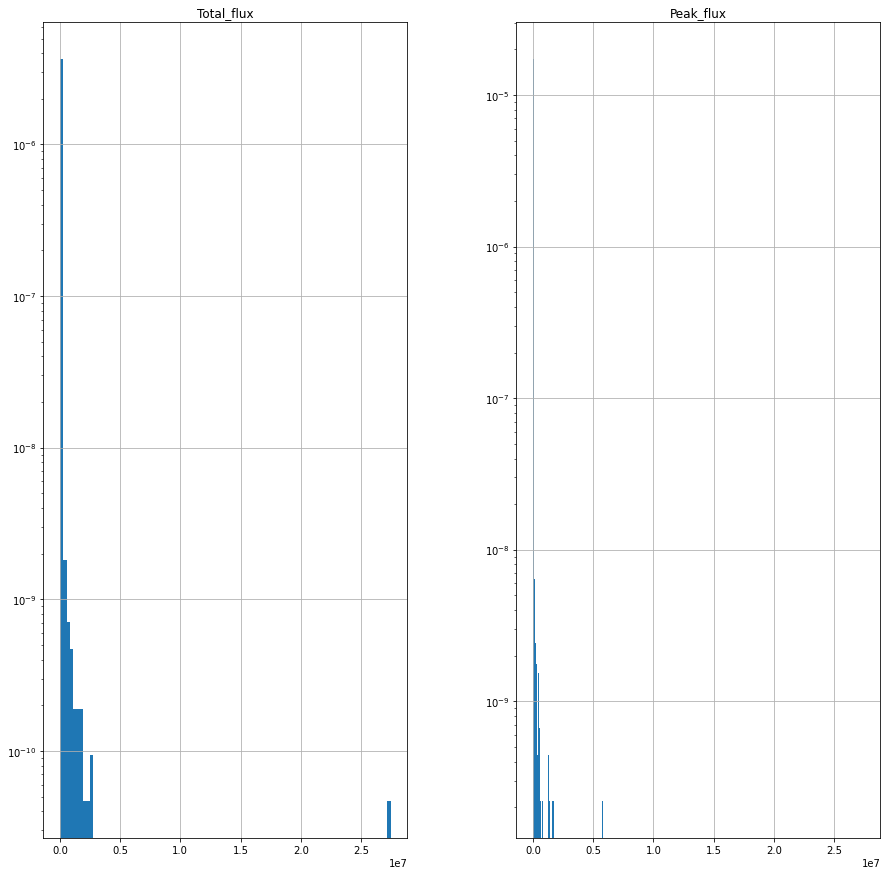

In [7]:
X[['Total_flux', 'Peak_flux']].hist(figsize=(15,15), 
                                                 bins=100, sharex=True, density=True, stacked=True, log=True)

array([[<AxesSubplot:title={'center':'F_MIPS_24'}>,
        <AxesSubplot:title={'center':'F_PACS_100'}>],
       [<AxesSubplot:title={'center':'F_PACS_160'}>,
        <AxesSubplot:title={'center':'F_SPIRE_250'}>],
       [<AxesSubplot:title={'center':'F_SPIRE_350'}>,
        <AxesSubplot:title={'center':'F_SPIRE_500'}>]], dtype=object)

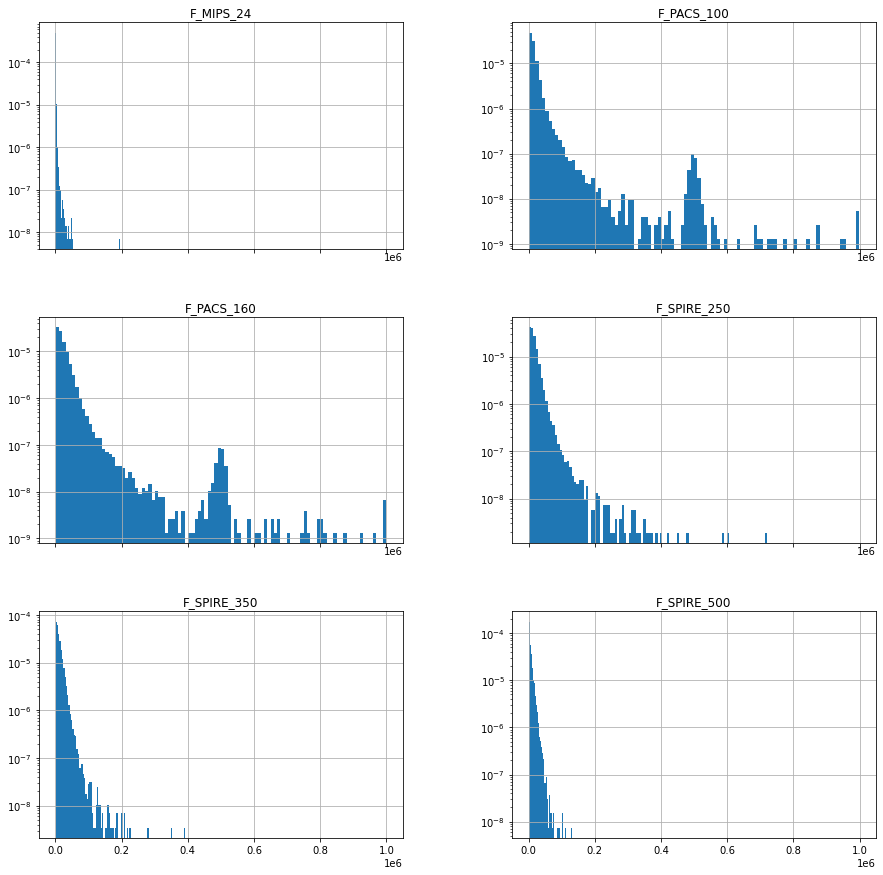

In [8]:
X[['F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350', 'F_SPIRE_500']].hist(figsize=(15,15), 
                                                 bins=100, sharex=True, density=True, stacked=True, log=True)

array([[<AxesSubplot:title={'center':'I_flux_corr'}>,
        <AxesSubplot:title={'center':'z_flux_corr'}>,
        <AxesSubplot:title={'center':'y_flux_corr'}>],
       [<AxesSubplot:title={'center':'J_flux_corr'}>,
        <AxesSubplot:title={'center':'H_flux_corr'}>,
        <AxesSubplot:title={'center':'K_flux_corr'}>],
       [<AxesSubplot:title={'center':'Ks_flux_corr'}>,
        <AxesSubplot:title={'center':'ch1_flux_corr'}>,
        <AxesSubplot:title={'center':'ch2_flux_corr'}>],
       [<AxesSubplot:title={'center':'ch3_flux_corr'}>,
        <AxesSubplot:title={'center':'ch4_flux_corr'}>, <AxesSubplot:>]],
      dtype=object)

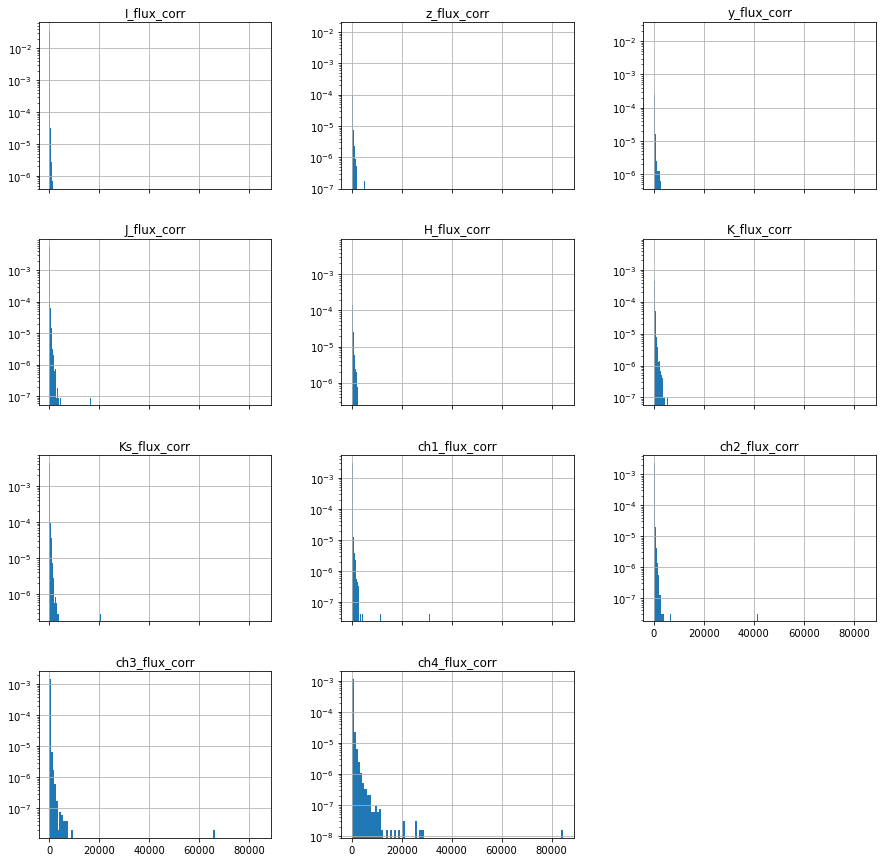

In [15]:
include = ['I_flux_corr', 'z_flux_corr', 'y_flux_corr', 'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 
           'Ks_flux_corr', 'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr']
X[include].hist(figsize=(15,15), bins=100, sharex=True, density=True, stacked=True, log=True)

array([[<AxesSubplot:title={'center':'NUV_flux_corr'}>,
        <AxesSubplot:title={'center':'u_flux_corr'}>,
        <AxesSubplot:title={'center':'Bw_flux_corr'}>],
       [<AxesSubplot:title={'center':'R_flux_corr'}>,
        <AxesSubplot:title={'center':'r_rcs_flux_corr'}>,
        <AxesSubplot:title={'center':'g_flux_corr'}>],
       [<AxesSubplot:title={'center':'nb921_hsc_flux_corr'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

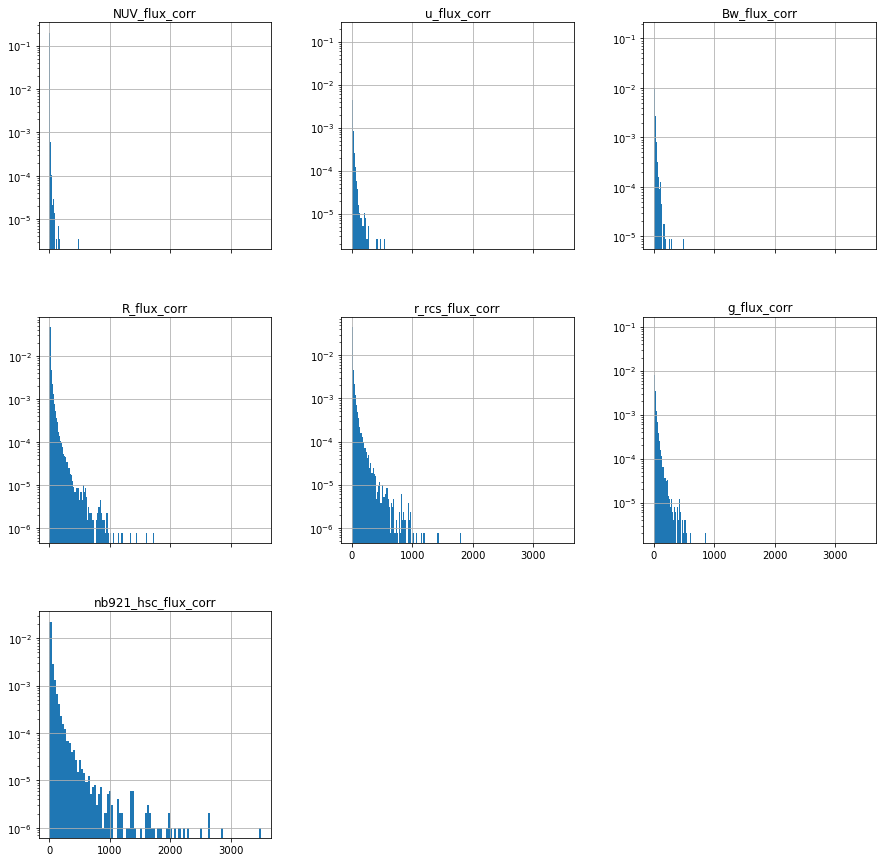

In [19]:
include = ['NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 
           'R_flux_corr', 'r_rcs_flux_corr', 'g_flux_corr', 
           'nb921_hsc_flux_corr']
X[include].hist(figsize=(15,15), bins=100, sharex=True, density=True, stacked=True, log=True)